In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from alibi.explainers import KernelShap
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
import keras_tuner as kt

In [2]:
# Load the TensorBoard notebook extension.
#%load_ext tensorboard

In [5]:
db = pd.read_csv("bpi19ite.csv")

In [6]:
db.shape

(1595923, 23)

In [7]:
db.nunique()

eventID                             1595923
case Spend area text                     20
case Company                              4
case Document Type                        3
case Sub spend area text                135
case Purchasing Document              76349
case Purch. Doc. Category name            1
case Vendor                            1975
case Item Type                            6
case Item Category                        4
case Spend classification text            3
case Source                               1
case Name                              1899
case GR-Based Inv. Verif.                 2
case Item                               490
case concept:name                    251734
case Goods Receipt                        2
event User                              628
event org:resource                      628
event concept:name                       42
event Cumulative net worth (EUR)      25221
event time:timestamp                 167432
iteration                       

In [8]:
db.groupby(['case Name'])['event concept:name'].count()

case Name
vendor_0000    1715
vendor_0001      15
vendor_0002      18
vendor_0003    3042
vendor_0004      59
               ... 
vendor_1894      15
vendor_1895       5
vendor_1896       5
vendor_1897      29
vendor_1898      24
Name: event concept:name, Length: 1899, dtype: int64

<Axes: ylabel='event concept:name'>

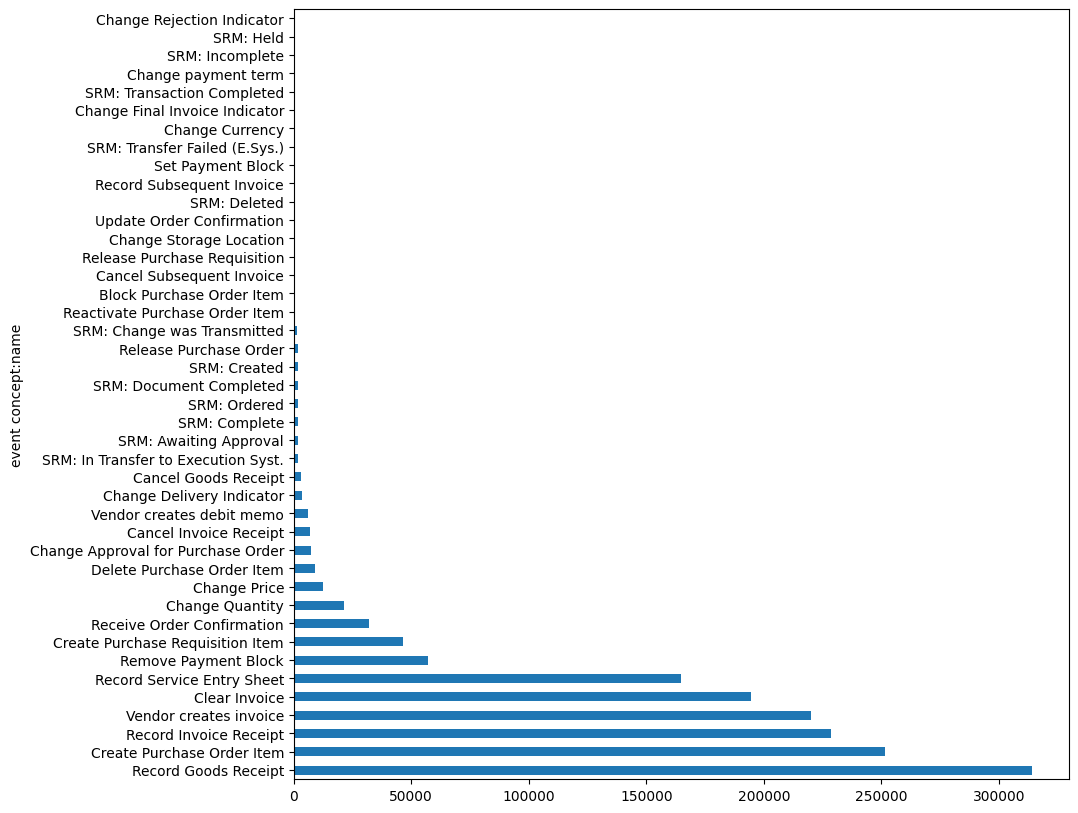

In [9]:
db['event concept:name'].value_counts().plot(kind='barh',figsize=(10,10))

In [8]:
# feature to drop
# drop = ['eventID ','case Purch. Doc. Category name','case Source','event time:timestamp']
# db = db.drop(drop,axis=1)

In [11]:
iteration = db.pop('iteration')

In [12]:
# target1 = train['class'].shift(1)
# target2 = test['class'].shift(1)
target = np.where(iteration.shift(1) >= 3,1,0)

In [13]:
# normalize data (this is important for model convergence)
def encode(db):
    dtypes = list(zip(db.dtypes.index, map(str, db.dtypes)))
    for k,dtype in dtypes:
        if dtype == 'object':
            db[k] = LabelEncoder().fit_transform(db[k])
    return db.astype('float')

In [14]:
data = encode(db)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data,target,train_size=0.7,shuffle=False)

In [38]:
data.shape[1]

22

In [39]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_hidden_activation1 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation2 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation3 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation4 = hp.Choice('activition', values=['relu','tanh'])
  hp_dense_activation = hp.Choice('activation', values=['softmax','sigmoid'])
  
  
  model.add(tf.keras.layers.Reshape((data.shape[1],-1),input_shape=(data.shape[1],)))
  model.add(layers.Conv1D(hp_units1, 3, activation = hp_hidden_activation1))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.Conv1D(hp_units2, 3, activation=hp_hidden_activation2))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.Conv1D(hp_units3, 3, activation=hp_hidden_activation3))
  model.add(layers.MaxPooling1D())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())
      
  model.add(layers.Flatten())
  model.add(layers.Dense(hp_units4, activation=hp_hidden_activation4))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1,activation = hp_dense_activation))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [40]:
# model = tf.keras.models.Sequential([
    
#     layers.Conv1D(128,3,activation='relu', input_shape=(22, 1)),
#     layers.Dropout(0.2),
#     layers.BatchNormalization(),
    
#     layers.Conv1D(64,3,activation='relu'),
#     layers.Dropout(0.2),
#     layers.BatchNormalization(),
    
#     layers.Flatten(),
#     layers.Dropout(0.2),
#     layers.BatchNormalization(),
    
#     # layers.Dense(64,activation='relu'),
#     # layers.Dropout(0.2),
#     # layers.BatchNormalization(),
    
#     layers.Dense(1,activation='sigmoid')
# ])

In [44]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

/home/modzo/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
sm_train,sm_test,sy_train,sy_test = train_test_split(x_train,y_train,train_size=0.1,shuffle=False)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [46]:
tuner.search(sm_train, sy_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 01m 05s]
val_accuracy: 0.9278968572616577

Best val_accuracy So Far: 0.9649554491043091
Total elapsed time: 00h 21m 27s


In [47]:
model_cnn = tuner.hypermodel.build(best_hps)

/home/modzo/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# model.compile(optimizer='adam',
#               loss = tf.keras.losses.BinaryCrossentropy(),
#               metrics = ['accuracy']
#              )

In [49]:
# model.summary()

In [50]:
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 22, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 448)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 448)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 448)        │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 18, 448)        │       602,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 18, 448)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 448)        │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 16, 448)        │       602,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 448)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 448)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 448)         │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 448)            │     1,606,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 448)            │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,820,609 (10.76 MB)

 Trainable params: 2,817,025 (10.75 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [51]:
# # Our vectorized labels
# y_train = np.asarray(x_train.columns).astype('float32').reshape((-1,1))
# y_test = np.asarray(x_test.columns).astype('float32').reshape((-1,1))

In [52]:
# x_train = tf.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
# x_test = tf.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [53]:
# dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [54]:
# for feat, targ in dataset.take(2):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [55]:
# train_dataset = dataset.shuffle(len(x_train)).batch(300)      

In [56]:
data.shape

(1595923, 22)

In [57]:

early = EarlyStopping(min_delta = 0.001, patience=25, restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [58]:
x_train.shape

(1117146, 22)

In [59]:
history = model_cnn.fit(x_train,y_train,
                    batch_size=256,
                    epochs = 100,       
                    validation_data=(x_test,y_test),
                    callbacks=[early]
                   )

Epoch 1/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8941 - loss: 0.3083 - val_accuracy: 0.9408 - val_loss: 0.1934
Epoch 2/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9500 - loss: 0.1814 - val_accuracy: 0.9461 - val_loss: 0.1851
Epoch 3/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9512 - loss: 0.1747 - val_accuracy: 0.9464 - val_loss: 0.1835
Epoch 4/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9517 - loss: 0.1716 - val_accuracy: 0.9458 - val_loss: 0.1814
Epoch 5/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9518 - loss: 0.1703 - val_accuracy: 0.9456 - val_loss: 0.1832
Epoch 6/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9520 - loss: 0.1689 - val_accuracy: 0.9462 - val_loss: 0.1806
Epoch 7/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9522 - loss: 0.1679 - val_accuracy: 0.9465 - val_loss: 0.1803
Epoch 8/100
4364/4364 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9524 -

In [32]:
#%tensorboard --logdir logs/fit

In [60]:
model_cnn.save('cnn_model_optimized.h5')

In [61]:
score = model_cnn.evaluate(x_test,y_test)

14962/14962 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9472 - loss: 0.1742


In [62]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.17356793582439423 / Test accuracy: 0.9474577903747559


In [63]:
model_cnn.save('modelcnn.h5')

In [64]:
history_df = pd.DataFrame(history.history)

<Axes: >

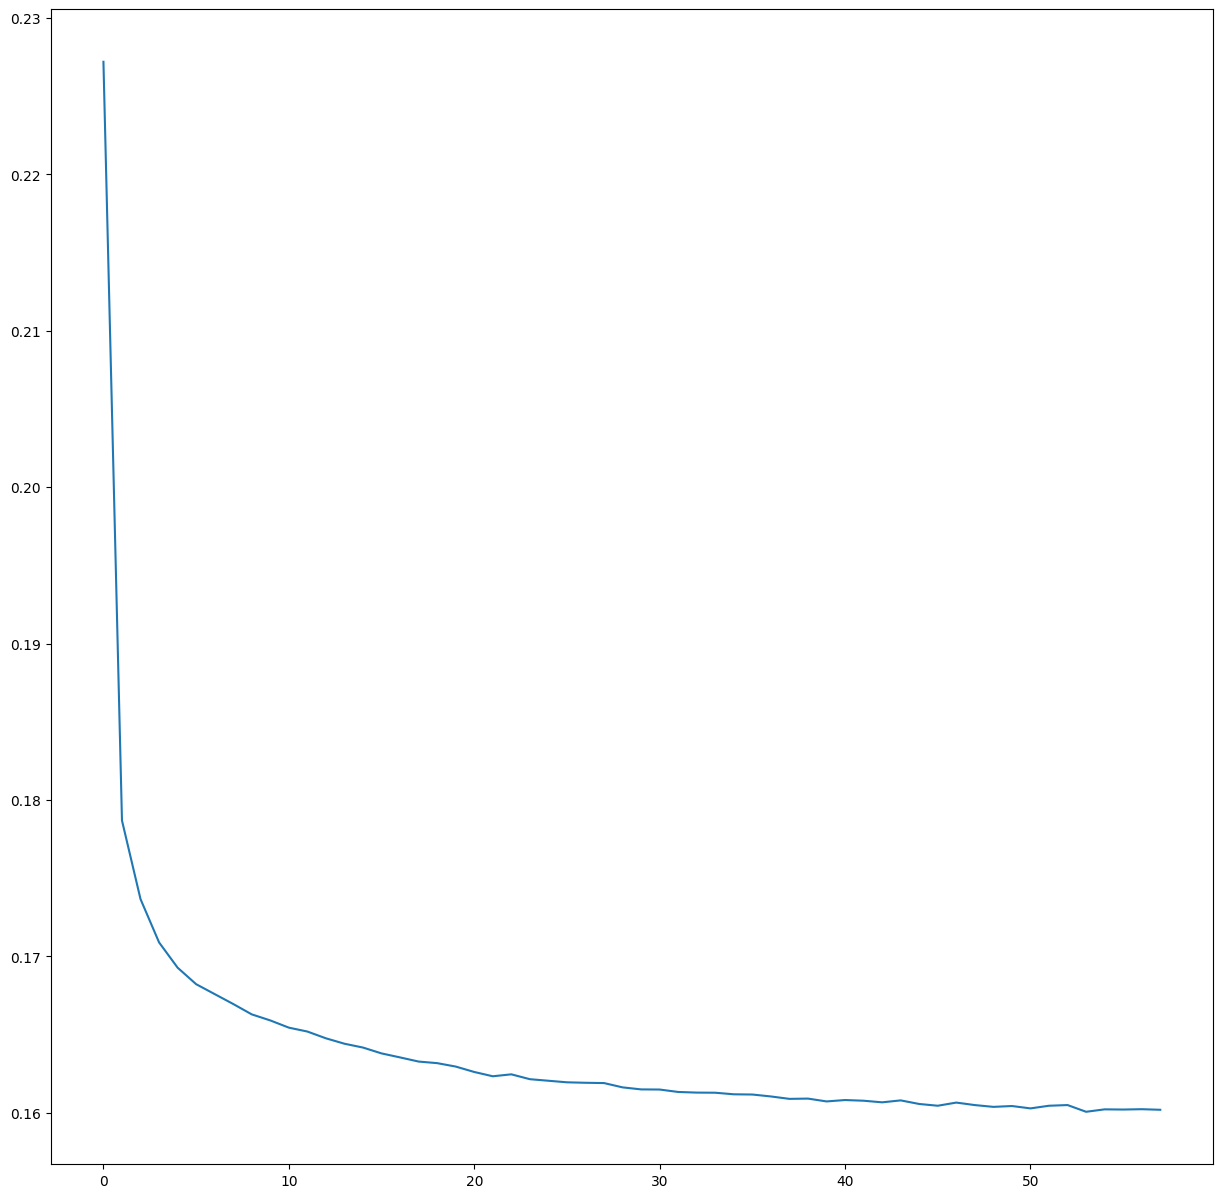

In [65]:
plt.figure(figsize=(15,15))
history_df['loss'].plot()

In [66]:
scaler = StandardScaler()
scaler.fit(x_test)

StandardScaler()

In [ ]:
def compare_instances(x, cf, features):
    """
    Show the difference in values between two instances.
    """
    x = x.astype('float64')
    cf = cf.astype('float64')
    for f, v1, v2 in zip(features, x[0], cf[0]):
        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v1 - v2, 7):^5}')

def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """

    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    fig, ax = plt.subplots(figsize=(10, 10))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    return ax, fig

In [43]:
x = np.array(x_test.iloc[2000]).reshape(1, -1)
#x = x_test.iloc[2000]
x.shape

(1, 22)

In [59]:
from alibi.explainers import KernelShap

predict_fn = lambda x: model(scaler.transform(x))

explainer = KernelShap(predict_fn, task='classification')

explainer.fit(x_test[0:1000])

result = explainer.explain(x)

plot_importance(result.shap_values[0], x_test.columns, 0)

Large datasets can cause slow runtimes for shap. The background dataset provided has 1000 records. Consider passing a subset or allowing the algorithm to automatically summarize the data by setting the summarise_background=True orsetting summarise_background to 'auto' which will default to 300 samples!
c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



ResourceExhaustedError: Exception encountered when calling layer "conv1d" "                 f"(type Conv1D).

{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[2084000,20,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:BiasAdd]

Call arguments received by layer "conv1d" "                 f"(type Conv1D):
  • inputs=tf.Tensor(shape=(2084000, 22, 1), dtype=float32)

In [45]:
np.array(x_test.columns)

array(['eventID ', 'case Spend area text', 'case Company',
       'case Document Type', 'case Sub spend area text',
       'case Purchasing Document', 'case Purch. Doc. Category name',
       'case Vendor', 'case Item Type', 'case Item Category',
       'case Spend classification text', 'case Source', 'case Name',
       'case GR-Based Inv. Verif.', 'case Item', 'case concept:name',
       'case Goods Receipt', 'event User', 'event org:resource',
       'event concept:name', 'event Cumulative net worth (EUR)',
       'event time:timestamp'], dtype=object)

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\modou\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\m

array([[<AxesSubplot:xlabel='case Goods Receipt', ylabel='ALE'>]],
      dtype=object)

<Figure size 1000x1000 with 0 Axes>

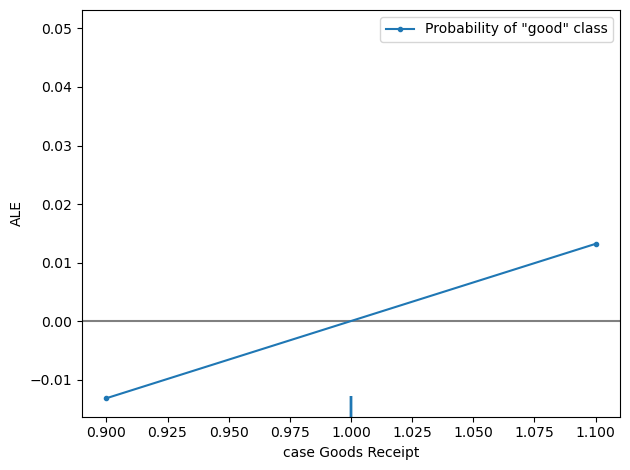

In [58]:
predict_fn = lambda x: model(scaler.transform(x)).numpy()[:, 0]
ale = ALE(predict_fn, feature_names=x_test.columns)
exp = ale.explain(x)
plt.figure(figsize=(10,10))
plot_ale(exp, features=['case Goods Receipt'], line_kw={'label': 'Probability of "good" class'})

In [47]:
y_test.reshape(-1,)

array([1, 1, 1, ..., 0, 0, 0])

In [63]:
explainer = dx.Explainer(model, x_test, y_test.reshape(-1,), label='Loops')

Preparation of a new explainer is initiated

  -> data              : 478777 rows 22 cols
  -> target variable   : 478777 values
  -> model_class       : keras.engine.sequential.Sequential (default)
  -> label             : Loops
  -> predict function  : <function yhat_tf_regression at 0x00000215B4184820> will be used (default)
1/1 [==============================] - 0s 19ms/step
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
14962/14962 [==============================] - 12s 821us/step
  -> predicted values  : min = 0.00106, mean = 0.132, max = 0.899
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
14962/14962 [==============================] - 12s 812us/step
  -> residuals         : min = -0.899, mean = -0.0103, max = 0.998
  -> model_info        : package keras

A new explainer has been created!


In [64]:
explainer.model_performance()

,mse,rmse,r2,mae,mad
Loops,0.055615,0.235828,0.481298,0.112359,0.036792


In [65]:
explainer.model_parts().plot()

32/32 [==============================] - 0s 952us/step
